In [99]:
import pandas as pd
import numpy as np
from scipy.io import wavfile
import shutil

from pathlib import Path

import librosa
from librosa.filters import mel as librosa_mel_fn
from librosa.feature import melspectrogram

import matplotlib.pyplot as plt
import torch

In [106]:
gen_mel = np.load('/people/torres_guarin/work/hifi-gan/Naija/mel_specs/JOS_19-119.npy')
og_mel = np.load('/people/torres_guarin/work/hifi-gan/Naija/og_mel_specs/JOS_19-119.npy')
sr, audio = wavfile.read('/people/torres_guarin/work/hifi-gan/Naija/wavs/JOS_19-119.wav')

In [110]:
print(gen_mel.shape)
print(og_mel.shape)
# print(og_og_mel.shape)
print(audio.shape)

(80, 566)
(80, 566)
(145067,)


In [111]:
comp_mel = np.load('Naija/debug_files/JOS_19-119_computed_spectrogram.npy')
generated_audio = np.load('Naija/debug_files/JOS_19-119_generated_audio.npy')
generated_spectrogram = np.load('Naija/debug_files/JOS_19-119_generated_spectrogram.npy')
input_spectrogram = np.load('Naija/debug_files/JOS_19-119_input_spectrogram.npy')
original_audio = np.load('Naija/debug_files/JOS_19-119_original_audio.npy')

In [112]:
print(comp_mel.shape)
print(generated_audio.shape)
print(generated_spectrogram.shape)
print(input_spectrogram.shape)
print(original_audio.shape)

(1, 80, 567)
(1, 1, 144896)
(1, 80, 567)
(1, 80, 566)
(1, 1, 145067)


In [133]:
audio

array([-845., -831., -799., ...,   -2.,   -2.,   -2.], dtype=float32)

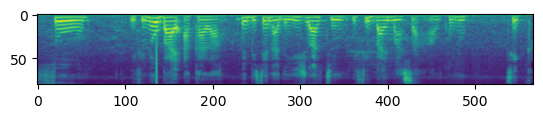

In [123]:
plt.imshow(comp_mel[0])

In [140]:
comp_mel[0]

array([[-2.7271435, -1.8873045, -2.1321197, ..., -2.741022 , -2.9267743,
        -3.2847686],
       [-2.777709 , -2.3754685, -2.288733 , ..., -3.2559812, -3.1945517,
        -3.8182893],
       [-3.3957953, -3.797056 , -4.095219 , ..., -3.641736 , -4.2541056,
        -5.516637 ],
       ...,
       [-6.837973 , -6.0833793, -5.7269397, ..., -6.4745026, -6.9502983,
        -7.9103274],
       [-6.866115 , -6.0054684, -5.3276234, ..., -6.9583707, -7.5638776,
        -8.448054 ],
       [-6.5146117, -5.644223 , -5.0715375, ..., -7.229651 , -7.542737 ,
        -8.227246 ]], dtype=float32)

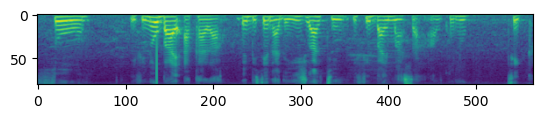

In [124]:
plt.imshow(input_spectrogram[0])

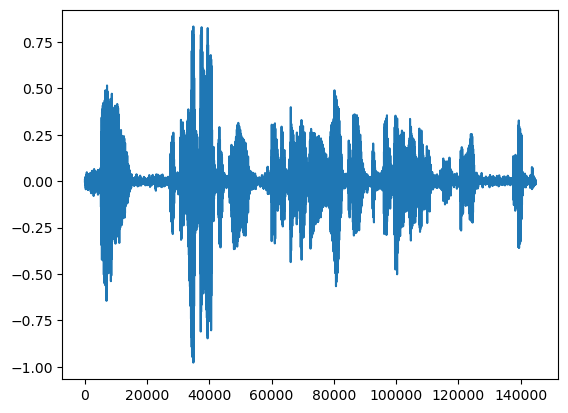

In [147]:
plt.plot(generated_audio.flatten())

In [148]:
generated_audio

array([[[-0.00180929,  0.00595335,  0.00269136, ..., -0.00168251,
          0.00107921,  0.00353232]]], dtype=float32)

In [149]:
generated_audio.shape

(1, 1, 144896)

In [146]:
input_spectrogram.shape

(1, 80, 566)

In [125]:
mel_basis = {}
hann_window = {}

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    y = torch.FloatTensor(y)
    y = y.unsqueeze(0)
    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, 
                             n_fft=n_fft, 
                             n_mels=num_mels, 
                             fmin=fmin, 
                             fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    print('audio shape before weird thing', y.shape)
    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft)/2), int((n_fft)/2)), mode='reflect')
    y = y.squeeze(1)
    print('audio shape after weird thing', y.shape)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=False)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec


In [141]:
mel = mel_spectrogram(y=audio/32768, n_fft=1024, num_mels=80, sampling_rate=sr,
                      hop_size=256, win_size=1024, fmin=0.0, fmax=8000, center=False)

audio shape before weird thing torch.Size([1, 145067])
audio shape after weird thing torch.Size([1, 146091])


In [142]:
mel.shape

torch.Size([1, 80, 567])

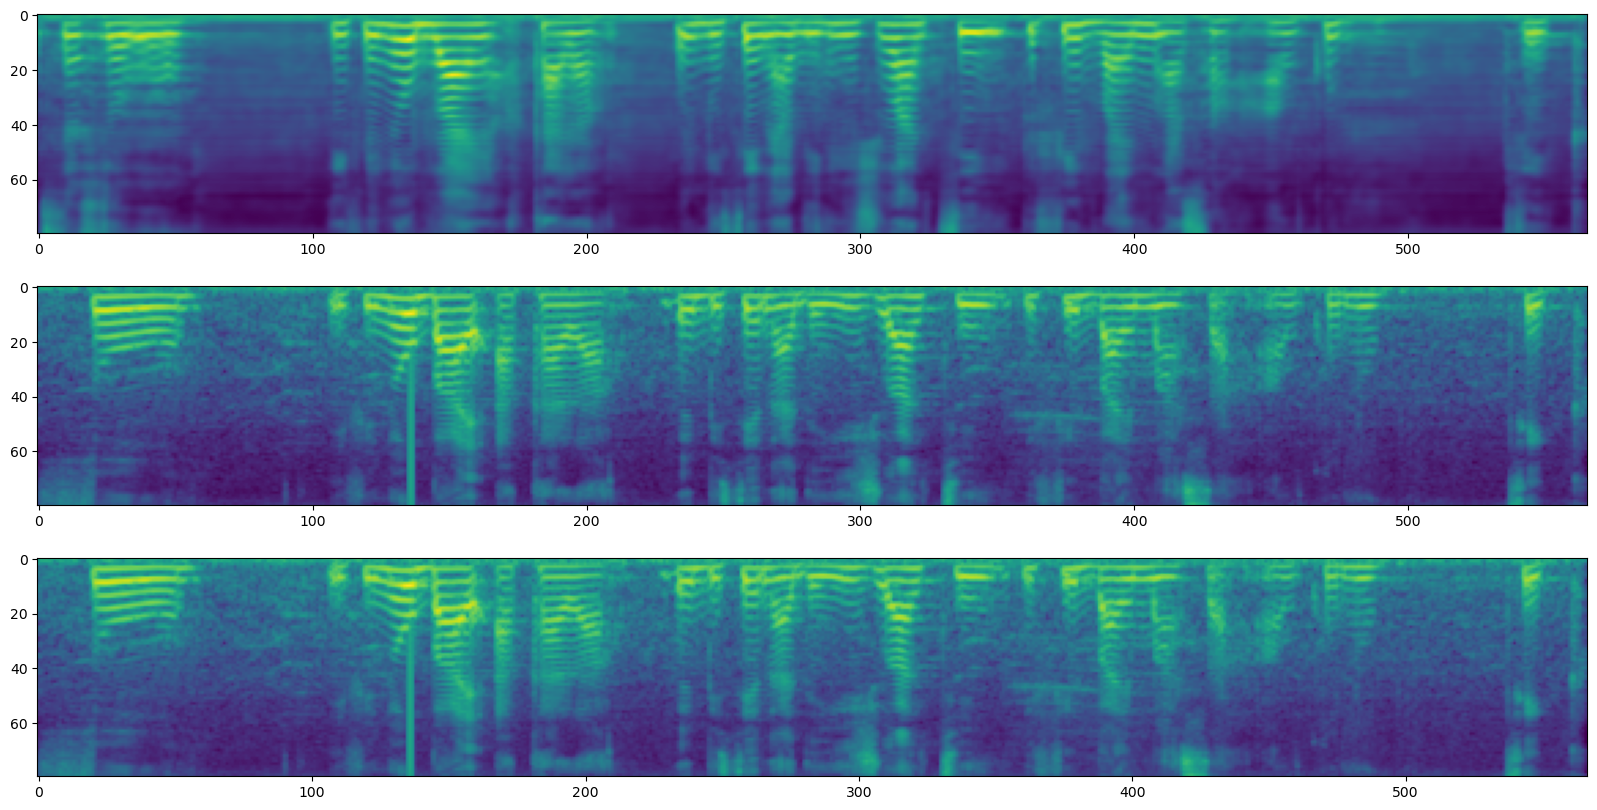

In [143]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))
ax1.imshow(gen_mel)
ax2.imshow(og_mel)
ax3.imshow(mel[0].cpu().numpy())
plt.show()

In [144]:
mel

tensor([[[-2.5656, -1.8746, -2.1482,  ..., -2.7268, -3.0169, -3.3234],
         [-3.0352, -2.2471, -2.1708,  ..., -3.2577, -3.0003, -3.5928],
         [-2.8939, -3.3210, -3.4489,  ..., -3.3733, -4.0916, -5.0144],
         ...,
         [-5.3548, -4.6408, -4.3828,  ..., -6.6811, -7.1259, -7.8740],
         [-5.4080, -4.8460, -4.5047,  ..., -6.5532, -6.9350, -8.1924],
         [-5.8728, -4.7042, -4.4658,  ..., -5.7528, -6.2719, -6.9863]]])

In [131]:
og_mel

array([[-2.5656264, -1.8745756, -2.1482341, ..., -2.553966 , -2.7267883,
        -3.0169165],
       [-3.0351598, -2.247063 , -2.1708345, ..., -3.5297363, -3.2577374,
        -3.000256 ],
       [-2.8938718, -3.3209624, -3.4488704, ..., -3.0905433, -3.3732705,
        -4.09161  ],
       ...,
       [-5.354786 , -4.6407537, -4.382767 , ..., -6.6139803, -6.6811323,
        -7.1258864],
       [-5.4080453, -4.8460307, -4.5046678, ..., -6.328116 , -6.553157 ,
        -6.9349685],
       [-5.8728256, -4.704155 , -4.465752 , ..., -5.5411086, -5.752808 ,
        -6.2719007]], dtype=float32)

In [59]:
og_mel[:, -1]

array([-6.889299 , -6.1463175, -6.240707 , -6.723457 , -6.276813 ,
       -5.324244 , -5.4792404, -5.9832435, -5.961692 , -6.494639 ,
       -6.5242705, -7.3524637, -7.352728 , -6.788674 , -7.0148892,
       -7.1621494, -7.6289268, -7.4011626, -7.731983 , -7.4668994,
       -7.2039795, -7.2504764, -7.01547  , -6.955703 , -7.6516986,
       -7.454595 , -8.092903 , -7.4981103, -8.165266 , -7.5211596,
       -7.546781 , -7.904107 , -7.745453 , -7.758478 , -8.183356 ,
       -7.6370454, -8.984476 , -8.545738 , -7.6043916, -7.7401175,
       -7.8057346, -7.854069 , -7.6127634, -7.7983584, -8.820483 ,
       -8.922798 , -7.948767 , -7.800378 , -7.8753448, -8.427507 ,
       -8.600843 , -9.010238 , -8.867369 , -8.112136 , -8.70567  ,
       -8.540231 , -8.456296 , -8.643652 , -8.322459 , -8.292631 ,
       -8.379819 , -7.724416 , -7.7967973, -8.350274 , -7.9321485,
       -7.514584 , -7.282071 , -6.5852876, -6.255152 , -6.0897136,
       -5.5394244, -5.9007936, -5.131398 , -4.839515 , -5.1832

In [60]:
mel[0][:, -2]

tensor([-4.7366, -5.2119, -5.5909, -5.6511, -6.4086, -5.1014, -4.3421, -5.2618,
        -5.4539, -4.9295, -5.4340, -5.7142, -6.0683, -6.4628, -6.4510, -5.9320,
        -6.0246, -6.1589, -5.9939, -6.6735, -6.2754, -6.3969, -6.3630, -6.3231,
        -6.1602, -6.1081, -5.8585, -6.3172, -7.1748, -7.2675, -6.3421, -6.6764,
        -6.9142, -6.3972, -7.0280, -7.1490, -7.0774, -6.5549, -6.3456, -6.7780,
        -6.1066, -6.4733, -6.8229, -6.6820, -6.7153, -6.8062, -7.3449, -6.9533,
        -7.3672, -7.7593, -7.4147, -7.4733, -7.3390, -6.8835, -7.0904, -7.1001,
        -7.1611, -7.2590, -6.7815, -6.8034, -6.7550, -6.5188, -6.1448, -6.7285,
        -6.6231, -5.7070, -5.4899, -5.2455, -4.8679, -4.7422, -4.4307, -4.6934,
        -3.9637, -3.4278, -3.7614, -4.0050, -3.6874, -3.7237, -3.3343, -3.5513])

In [64]:
for i in range(len(mel[0])):
    print(i)
    print(np.sum(np.square(og_mel[:, -4]-mel[0][:, i].cpu().numpy())))

0
649.6066
1
712.25726
2
784.51245
3
868.0323
4
884.05884
5
757.72034
6
608.7865
7
580.3916
8
725.58264
9
848.05884
10
828.5587
11
776.9809
12
763.70135
13
751.7375
14
741.19604
15
654.6188
16
509.57217
17
458.2554
18
440.68726
19
405.08585
20
386.87213
21
415.4806
22
477.2283
23
533.9053
24
521.9479
25
771.7671
26
1003.8678
27
1188.6116
28
979.9133
29
787.18475
30
832.7488
31
852.2665
32
785.37036
33
616.32935
34
413.8166
35
252.26495
36
203.62222
37
169.50632
38
153.1231
39
195.45177
40
267.8019
41
375.3163
42
411.06363
43
479.43835
44
538.09753
45
661.4235
46
689.6728
47
641.9294
48
648.4149
49
666.2645
50
596.8158
51
504.07803
52
463.38098
53
391.4618
54
342.1361
55
356.18317
56
358.91516
57
294.57318
58
230.46298
59
165.51572
60
125.618324
61
97.09297
62
83.258286
63
91.42403
64
69.94548
65
54.93818
66
53.56579
67
57.15552
68
78.8612
69
91.603195
70
282.75974
71
489.7454
72
492.03656
73
404.8548
74
388.1078
75
393.904
76
459.18118
77
515.73083
78
517.6061
79
459.3476


In [14]:
mel_specs_dir = Path("Naija/mel_specs").resolve()
mel_specs_dir

PosixPath('/people/torres_guarin/work/hifi-gan/Naija/mel_specs')

In [19]:
source_path = Path("/people/torres_guarin/work/smallData/voice_features_phoneme/mel").resolve()
target_path = Path("/people/torres_guarin/work/hifi-gan/Naija/og_mel_specs").resolve()

In [27]:
for mel_path in mel_specs_dir.glob("*.npy"):
    og_path = mel_path
    for good_source in source_path.glob(f"*{mel_path.name}"):
        mel_path = good_source
    shutil.copy(mel_path, target_path/og_path.name)

In [31]:
for spec_path in target_path.glob("*.npy"):
    spectrogram = np.load(spec_path)
    # save transposed spectrogram
    np.save(spec_path, spectrogram.T)

In [2]:
data_path = Path('Naija').resolve()

In [18]:
train = pd.read_csv('Naija/train_new.txt', sep="|", header=None)
val = pd.read_csv('Naija/val_new.txt', sep="|", header=None)

In [19]:
train = train[[0,3]]
val = val[[0,3]]

In [20]:
len(train)

1372

In [21]:
len(val)

512

In [22]:
len(train) + len(val)

1884

In [23]:
mel_specs_names = {s.name[:-4] for s in (data_path/'mel_specs').iterdir()}

In [24]:
wavs_names = {s.name[:-4] for s in (data_path/'wavs').iterdir()}

In [25]:
mel_specs_names - wavs_names

set()

In [26]:
len(wavs_names - mel_specs_names)

0

In [27]:
for name in wavs_names - mel_specs_names:
    (data_path/'wavs'/f'{name}.wav').unlink()

In [28]:
train_names = set(train[0])
val_names = set(val[0])

In [29]:
wavs_names == (train_names | val_names)

True

In [30]:
len((train_names | val_names) - wavs_names)

0

In [31]:
new_train = train[train[0].isin(mel_specs_names)]
new_val = val[val[0].isin(mel_specs_names)]

In [32]:
(set(new_train[0]) | set(new_val[0])) - mel_specs_names

set()

In [43]:
new_train.to_csv('Naija/new_train.txt', sep="|", header=None, index=False)
new_val.to_csv('Naija/new_val.txt', sep="|", header=None, index=False)

In [1]:
command = "python train.py --config config_v1.json --fine_tuning True --checkpoint_interval 500"
print(command)

python train.py --config config_v1.json --fine_tuning True --checkpoint_interval 500


In [30]:
for file in Path('checkpoints/UNIVERSAL_V1').iterdir():
    if (file.name[:2] in ['g_', 'do']) and (file.name[-4:] != '0000'):
        file.unlink()

In [6]:
gen_mel = np.load('Naija/mel_specs/WAZP_07-14.npy')
og_mel = np.load('Naija/og_mel_specs/WAZP_07-14.npy')

In [7]:
print(gen_mel.shape)
print(og_mel.shape)

(80, 142)
(80, 142)
